In [20]:
import os
import pandas as pd
import numpy as np
import scipy.stats as spstat
import warnings
import matplotlib.pyplot as plt
from collections import OrderedDict
os.chdir('/plasticc-kit/data/') # change according to the correct folder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings

In [12]:
train = pd.read_csv('plasticc_train_lightcurves.csv.gz')
train_meta = pd.read_csv('plasticc_train_metadata.csv')
train_meta.head()
test_meta = pd.read_csv('plasticc_test_metadata.csv')
test = pd.read_csv('plasticc_test_lightcurves_03.csv.gz') #or any other test data

In [13]:
band_names = ['u','g','r','i','z','y']
Nbands = len(band_names)

In [17]:
# GP interpolation of the light curves
def GPint(lc,band,ismag=True):
    band_names = ['u','g','r','i','z','y']
    bandnum = np.where(band == np.array(band_names))[0][0]
    times = lc.mjd[lc.passband==bandnum].to_numpy()
    flux = lc.flux[lc.passband==bandnum].to_numpy()
    flux_err = lc.flux_err[lc.passband==bandnum].to_numpy()

    ind = flux>0
    
    x_train = times[ind]
    y = flux[ind]
    y_err = flux_err[ind]
    
    if x_train.size<2:
        return 0,0,0,False

    if ismag:   
        y_err = 2.5*np.log10(1+y_err/y)
        y = 2.5*np.log10(y)

    meany = np.mean(y)
    # meany = 0
    noisestd = np.std(y_err)
    Nmeas = np.alen(y)

    kernel = ConstantKernel(constant_value=1, constant_value_bounds=(0.01, 10))*RBF(length_scale=20.0, length_scale_bounds=(5, 100)) #might want to play with the bounds
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha=y_err**2)
    gaussian_process.fit(x_train.reshape(-1, 1), y-meany)
    
    X = np.arange(times[0],times[-1],0.1).reshape(-1,1)
    
    yint, ystd = gaussian_process.predict(X, return_std=True)
    yint+=meany
    return X,yint, ystd, True 
    # print(gaussian_process.kernel_)


In [15]:
def exractFeatures(lctable,metatable,N=None):
    # idarr,ia,ic = np.unique(lctable.object_id,return_index=True,return_inverse=True)
    metatable =  metatable.loc[metatable.true_target<900]
    
    idarr, x_ind, y_ind = np.intersect1d(lctable.object_id,metatable.object_id,return_indices=True) 
    
    if N is None:
        N = idarr.size
    
    metatable = metatable.iloc[y_ind[:N]]
    bands = ['u','g','r','i','z','y']
    Nbands = len(bands)

    maxmag = np.zeros((N,Nbands))
    widthmag = np.zeros((N,Nbands))
    indgood = np.full((N,len(bands)), True) #not using this anymore
    
    featureTable = pd.DataFrame(metatable[['hostgal_specz','hostgal_photoz']])
    featureTable.index = np.arange(N)
    for i in tqdm(range(N)):

        lc = lctable[lctable['object_id'] == metatable.object_id.iloc[i]]
        for j,band in enumerate(bands):
            bandnum = np.where(band==np.array(band_names))[0][0]

            times, mag,ystd, success = GPint(lc,band,ismag=True,time_range = 100)

            maxmag[i,j] = np.nanmax(mag)
            if np.isnan(maxmag[i,j]) or not success:
                indgood[i,j]=False
                continue
                
            imax = np.nanargmax(mag)
            # print(imax, maxmag[i,j],mag[0])
            i1 = np.where(maxmag[i,j]-mag[:imax]>1)[0]   
            i2 = np.where(maxmag[i,j]-mag[imax+1:]>1)[0]

            if i1.size == 0:
                i1= np.nanargmin(mag[:imax+1])
            else:
                i1=i1[-1]
            if i2.size == 0:
                i2=np.nanargmin(mag[imax:])
            else:
                i2=i2[0] 
            widthmag[i,j] = times[i2+imax]-times[i1]
            
    maxmagdf = pd.DataFrame(maxmag,columns=[band+'_max' for band in band_names])
    widthmagdf = pd.DataFrame(widthmag,columns=[band+'_width' for band in band_names])
    featureTable = featureTable.join(maxmagdf,how='right')
    
    featureTable = featureTable.join(widthmagdf,how='right')
    y_label = metatable.true_target
    return featureTable,y_label

In [21]:
x_train_val,y_train_labels = exractFeatures(train,train_meta)
labels,ia,y_train_val = np.unique(y_train_labels,return_index=True,return_inverse=True)

  0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]/Users/amirsha/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amirsha/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 5. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amirsha/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower boun

In [413]:
x_test,y_test = exractFeatures(test,test_meta,N=1000)
for i,label in enumerate(labels):
    y_test[y_test==label] = i

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


In [323]:
def plotLC(idnum,band):
    lc = train[train['object_id'] == train_meta.object_id.iloc[idnum]]

    times = lc.mjd[lc.passband==bandnum].to_numpy()
    y = lc.flux[lc.passband==bandnum].to_numpy()
    indpeak = np.argmax(y)
    y_err = lc.flux_err[lc.passband==bandnum].to_numpy()

    y_err = np.log10(1+y_err/y)
    y = 2.5*np.log10(y)

    plt.figure(figsize=(13,8))
    plt.errorbar(times,y,yerr=y_err,fmt='o')
    plt.title(labelnames[train_meta.true_target.iloc[idnum]])

    times, mag,ystd, success = GPint(lc,band,ismag=True)
    maxmag = np.nanmax(mag)

    imax = np.nanargmax(mag)
    # print(imax, maxmag[i,j],mag[0])
    i1 = np.where(maxmag-mag[:imax]>1)[0]
    i2 = np.where(maxmag-mag[imax+1:]>1)[0]
    if i1.size == 0:
        i1= np.nanargmin(mag[:imax+1])
    else:
        i1=i1[-1]
    if i2.size == 0:
        i2=np.nanargmin(mag[imax:])+imax
    else:
        i2=i2[0] +imax
    plt.plot(times,mag)
    plt.axvline(times[i1])
    plt.axvline(times[i2])

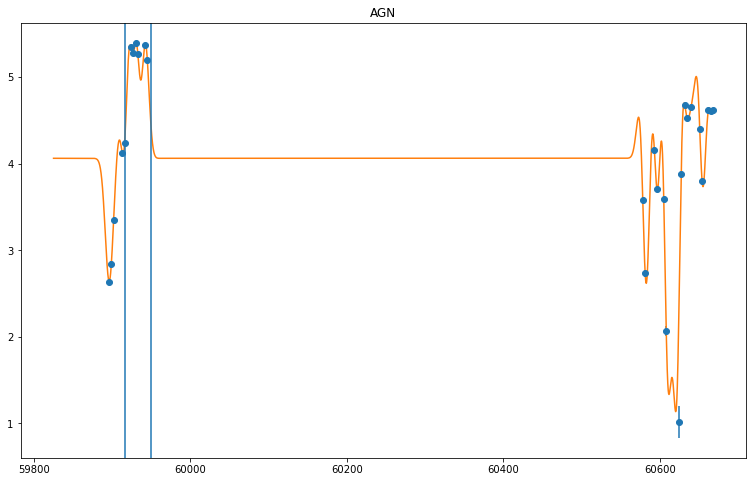

In [335]:
# some examples with marked widths
band = 'r'
bandnum = np.where(band == np.array(band_names))[0][0]
idnum = 29
idnum = 347
idnum = 444
idnum = 555
agn_ind = np.where(train_meta.target==88)[0]
idnum = agn_ind[47]
idnum = agn_ind[23]
plotLC(idnum,band)

In [408]:
np.savez('train_feature1',x_train_val=x_train_val,y_train_val=y_train_val)

In [414]:
np.savez('test_feature1',x_test=x_test,y_test=y_test)

In [325]:
x_train_val

hostgal_specz  hostgal_photoz      u_max     g_max      r_max     i_max  \
0             0.000           0.000   8.398837  7.955252  10.227225  8.038524   
1             1.818           1.627   2.398785  2.243750   2.424381  2.632759   
2             0.232           0.226   1.286238  1.250289   3.294731  3.788672   
3             0.304           0.281   3.268528  5.828868   5.924554  5.925247   
4             0.193           0.241   1.428416  4.359271   6.426668  7.277518   
...             ...             ...        ...       ...        ...       ...   
7843          0.000           0.000   4.244625  5.490568   3.971474  3.230708   
7844          0.172           2.561   6.079991  4.334050   0.976058  6.318068   
7845          0.000           0.000   3.588577  2.253689   3.386618  4.329970   
7846          0.000           0.000   3.812389  6.270198   3.560617  2.862820   
7847          0.000           0.000  10.031267  9.768104  12.258816  9.806660   

          z_max      y_max  u_width  g_width  r_width  i_width  z_width  \
0      7.894092   7.973811      5.0      8.6      5.2      7.3      8.4   
1      2.401688   2.288709     97.0     71.6     44.0     36.0     67.7   
2      4.018162   4.129057     84.5     13.6    128.5    115.0     99.9   
3      5.914421   5.496708    139.7     47.9     41.5     72.9     71.0   
4      7.044045   5.300036    499.5    135.2     95.9     70.0     81.3   
...         ...        ...      ...      ...      ...      ...      ...   
7843   3.614064   6.903827     26.2      8.0     36.1    498.9     18.8   
7844   6.422064   5.106835     11.2     33.2    970.1    136.1     37.3   
7845   3.059485   5.403355    461.1    653.2     20.8     37.9   1046.9   
7846   2.139082   5.836858     12.0      7.2      9.2    361.1    334.4   
7847  12.751490  12.639127    105.3    161.4     91.2    218.9     81.5   

      y_width  
0         7.2  
1       621.3  
2        97.3  
3       140.2  
4        77.1  
...       ...  
7843      7.2  
7844     12.6  
7845     15.1  
7846      8.4  
7847     91.9  

[7848 rows x 14 columns]

In [26]:
dict1 = np.load('train_feature1.npz')
x_train_val = dict1['x_train_val']
y_train_val = dict1['y_train_val']
x_train_val = pd.DataFrame(x_train_val,columns=['hostgal_specz', 'hostgal_photoz', 'u_max', 'g_max', 'r_max', 'i_max',
       'z_max', 'y_max', 'u_width', 'g_width', 'r_width', 'i_width', 'z_width',
       'y_width'])

dict1 = np.load('test_feature1.npz')
x_test = dict1['x_test']
y_test = dict1['y_test']

x_test = pd.DataFrame(x_test,columns=['hostgal_specz', 'hostgal_photoz', 'u_max', 'g_max', 'r_max', 'i_max',
       'z_max', 'y_max', 'u_width', 'g_width', 'r_width', 'i_width', 'z_width',
       'y_width'])

In [71]:
# choose which features to train with. Skip specz since it's not available for the test data
ind = ['specz' not in var for var in x_train_val.columns]
# ind = ['specz' not in var and 'width' not in var for var in x_train_val.columns] # case where you want to omit the widths

# ind = [True for val in ind]
x_train, x_validate, y_train, y_validate = train_test_split(x_train_val.iloc[:,ind], y_train_val, test_size=0.02, random_state=123) #split to train and validation. Not mandatory
x_test_in = x_test.iloc[:,ind]

In [88]:
# train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',verbosity=1, max_depth=4)
model.fit(x_train, y_train)

/Users/amirsha/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [326]:
y_pred_val = model.predict(x_validate)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test_in)

In [91]:
# classify now with NN
import tensorflow as tf

modelNN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation='relu'),
  # tf.keras.layers.Dropout(0.3),  
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(14, activation='softmax')
    
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

modelNN.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

modelNN.fit(x_train, y_train, epochs=800,validation_split=0.2,verbose=0)

In [92]:
modelNN.evaluate(x_train,  y_train, verbose=2)

241/241 - 0s - loss: 0.9810 - accuracy: 0.6614


[0.980993390083313, 0.6614224314689636]

In [103]:
modelNN.evaluate(x_test_in,  y_test, verbose=2)
y_pred_test = np.argmax(modelNN.predict(x_test_in),axis=1)

32/32 - 0s - loss: 1.2100 - accuracy: 0.5840


In [114]:
accuracy_val = accuracy_score(y_validate, y_pred_val)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(accuracy_train,accuracy_val,accuracy_test)

0.9526719542322195 0.7643312101910829 0.673


In [198]:
labelnames = {90:'SNIa',67:'SNIa-91bg',52:'SNIax',42:'SNII',62:'SNIbc',\
              95:'SLSN-I',15:'TDE',64:'KN',88:'AGN',92:'RRL',65:'M-dwarf',\
             16:'EB',53:'Mira',6:'muLens'}

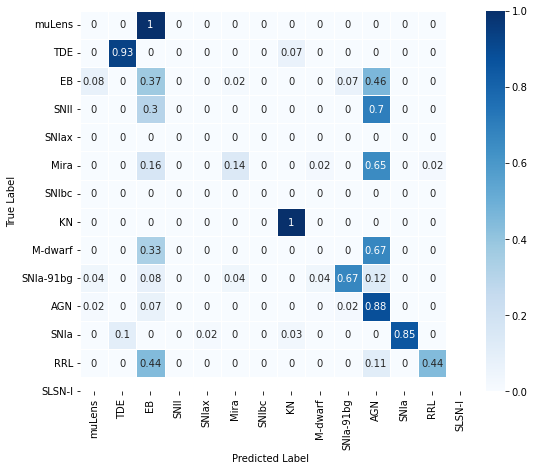

In [327]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = np.unique(train_meta.target)
labels = [labelnames[label] for label in labels]
cm = confusion_matrix(y_test, y_pred_test)
# cm = confusion_matrix(y_train, y_pred_train)
# cm = confusion_matrix(y_validate, y_pred_val)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm[np.isnan(cm)]=0
annot = np.around(cm, 2)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

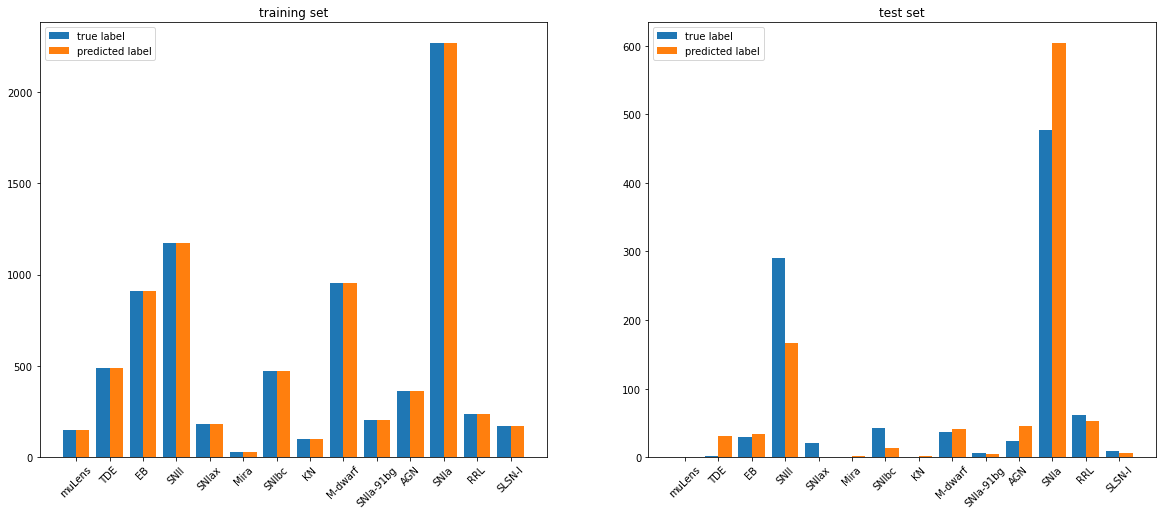

In [329]:
# compare distributions
%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(20,8))
width = 0.4 
labels = np.unique(train_meta.target)
labels = np.array([labelnames[label] for label in labels])
xvals = np.arange(np.alen(labels))

counts = np.bincount(y_train)
ax[0].bar(xvals-width/2,counts , width)

counts = np.bincount(y_train)
ax[0].bar(xvals+width/2,counts , width)
ax[0].set_xticks(xvals, labels=labels,rotation = 45)

ax[0].set_title('training set')
ax[0].legend(['true label','predicted label'])

counts = np.bincount(y_test)
ax[1].bar(xvals-width/2,counts,width)

counts = np.bincount(y_pred_test)
ax[1].bar(xvals+width/2,counts,width)
ax[1].set_xticks(xvals, labels=labels,rotation = 45)

ax[1].set_title('test set')
ax[1].legend(['true label','predicted label'])